## План проекта "Sentiment Analysis"

### Формулировка задачи: бинарная классификация.

### 1. Постановка задачи
 Цель: определить эмоциональную окраску текста (положительная, отрицательная).
- Иследовать модели машинного обучения
- Иследовать методы преобразования текста, подходы классического машинного обучения 
- Используемые данные: imdb-dataset-of-50k-movie-reviews.
- Проверить качество предсказания алгоритмов с помощью метрик


### 2. Этапы реализации


#### Шаг 1. Сбор данных

**Скачивание датасета и подробное описание вынесено в отдельный notbook название "Загрузка_данных"**

#### Шаг 2.Загрузка и Предобработка данных
- Загрузка данных
- Очистка текста: удаление специальных символов, HTML тегов
- Токенизация
- Удаление стоп-слов
- Преобразование категорийной переменной

In [153]:
# Загрузка фреймворков и библиотек
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report,roc_auc_score,precision_recall_curve,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
import matplotlib.pyplot as plt
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool


In [69]:
# Загрузка датасета
data = pd.read_csv('C:/Users/Roman33/project/NLP/IMDB Dataset.csv')

In [70]:
# Вывод первых 5 строк 
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [71]:
# Информация по данным
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [72]:
# Проверка баланса классов
data['sentiment'].value_counts() 

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

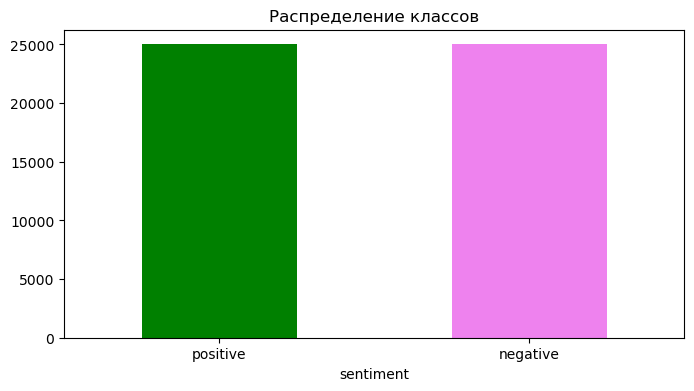

In [73]:
# Построим график 
class_counts = data['sentiment'].value_counts()
plt.figure(figsize=(8, 4))
class_counts.plot(kind='bar', color=['green', 'violet'])
plt.xticks(rotation=0)
plt.title("Распределение классов")
plt.show()

In [74]:
# просмотр стоп-слов
for word in sorted(ENGLISH_STOP_WORDS):
    print(word)

a
about
above
across
after
afterwards
again
against
all
almost
alone
along
already
also
although
always
am
among
amongst
amoungst
amount
an
and
another
any
anyhow
anyone
anything
anyway
anywhere
are
around
as
at
back
be
became
because
become
becomes
becoming
been
before
beforehand
behind
being
below
beside
besides
between
beyond
bill
both
bottom
but
by
call
can
cannot
cant
co
con
could
couldnt
cry
de
describe
detail
do
done
down
due
during
each
eg
eight
either
eleven
else
elsewhere
empty
enough
etc
even
ever
every
everyone
everything
everywhere
except
few
fifteen
fifty
fill
find
fire
first
five
for
former
formerly
forty
found
four
from
front
full
further
get
give
go
had
has
hasnt
have
he
hence
her
here
hereafter
hereby
herein
hereupon
hers
herself
him
himself
his
how
however
hundred
i
ie
if
in
inc
indeed
interest
into
is
it
its
itself
keep
last
latter
latterly
least
less
ltd
made
many
may
me
meanwhile
might
mill
mine
more
moreover
most
mostly
move
much
must
my
myself
name
namely
neithe

In [75]:
# Функция для преобразования текста
def preproces_text(text):
    # Перевод в нижний регистр
    text = text.lower()
    # Удаляем все HTML теги
    text = re.sub(r'<.*?>', '', text)
    # Удаляем знаки препинания
    text = re.sub(r'[^\w\s]', '', text)
    # Токенизация
    tokens = text.split()
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]
    return ' '.join(tokens)

In [76]:
# Применение функции
data['review'] = data['review'].apply(preproces_text)


In [77]:
# Первые 5 строк 
data.head()

,review,sentiment
0,reviewers mentioned watching just 1 oz episode...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


In [78]:
# Последние 5 строк 
data.tail()

,review,sentiment
49995,thought movie did right good job wasnt creativ...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary schools n...,negative
49998,im going disagree previous comment maltin seco...,negative
49999,expects star trek movies high art fans expect ...,negative


In [79]:
# Преобразование категорийной переменной
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative' : 0})

### Шаг 3. Векторизация текста
- Разделение данных на обучающию и тестовую выборки
- Использование TF-IDF


In [80]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['sentiment'], test_size=0.20, random_state=42, stratify=data['sentiment'])

**stratify=data['sentiment'] разделяет на одинаковое соотношение положительных и отрицательных отзывов в тренировочных и тестовых наборах**

In [81]:
y_train.value_counts()

sentiment
1    20000
0    20000
Name: count, dtype: int64

In [82]:
y_test.value_counts()

sentiment
0    5000
1    5000
Name: count, dtype: int64

In [83]:
# Векторизация текста с помощью TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Шаг 4. Обучение модели
- LogisticRegression
- Random Forest
- Catboost
- LightGBM

### **LogisticRegression**

In [ ]:
# Гиперпараметры для модели
model_lg = LogisticRegression(
    penalty='l2',           # Тип регуляризации: 'l1', 'l2', 'elasticnet' или None
    dual=False,             # Устанавливается в True, если количество признаков больше, чем образцов (для 'l2' penalty)
    tol=1e-4,               # Точность для сходимости оптимизации
    C=1.0,                  # Обратная величина коэффициента регуляризации (чем меньше — тем сильнее регуляризация)
    fit_intercept=True,     # Включать ли смещение (bias term)
    intercept_scaling=1,    # Масштабирование интерсепта, если fit_intercept=True
    class_weight=None,      # Веса для классов для балансировки обучения ('balanced' или словарь)
    solver='lbfgs',         # Алгоритм оптимизации: 'newton-cg', 'lbfgs', 'liblinear', 'saga'
    max_iter=100,           # Максимальное количество итераций
    multi_class='auto',     # Метод для многоклассовой логистической регрессии ('auto', 'ovr', 'multinomial')
    warm_start=False,       # Использовать ли предыдущие решения для следующего обучения
    n_jobs=None,            # Количество потоков для параллельных вычислений (по умолчанию None)
    l1_ratio=None,          # Коэффициент для elasticnet penalty (между 0 и 1)
    verbose=0,              # Уровень выводимой информации
    random_state=None       # Инициализация генератора случайных чисел для воспроизводимости
)


In [84]:
# Обучение модели
model_lg = LogisticRegression(max_iter=100)
model_lg.fit(X_train_tfidf, y_train)

LogisticRegression()

In [85]:
# Предсказания
y_pred_lg = model_lg.predict(X_test_tfidf)

### Шаг 4.1 Метрики качества

#### Accuracy (Точность)
$$
\text{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}$$

In [86]:
accuracy = accuracy_score(y_test,y_pred_lg)
print(f'Точность модели: {accuracy:.4f}')

Точность модели: 0.8879


## Precision (Точность положительного класса)
$$
\text{Precision} = \frac{TP}{TP + FP}$$

In [87]:
precision = precision_score(y_test, y_pred_lg)
print(f'Точность модели: {precision:.4f}')

Точность модели: 0.8802


## Recall (Чувствительность, полнота)
$$
\text{Recall} = \frac{TP}{TP + FN}$$

In [89]:
recal = recall_score(y_test, y_pred_lg)
print(f'Точность модели: {recal:.4f}')

Точность модели: 0.8980


## F1-score (Гармоническое среднее Precision и Recall)
$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [91]:
f1 = f1_score(y_test, y_pred_lg)
print(f' Точность модели : {f1:.4f}')

 Точность модели : 0.8890


## ROC-AUC (Area Under the Receiver Operating Characteristic Curve)
- Это площадь под кривой ROC, которая строится по значениям чувствительности (Recall) и 1 - специфичность (False Positive Rate) при различных порогах:
$$
\text{AUC} = \int_{0}^{1} \text{ROC}(t) \, dt
$$
- где $$(\text{ROC}(t))$$ — кривая, отображающая зависимость чувствительности от 1 – специфичности при разных порогах.

In [92]:
# Получим вероятности положительного класса для тестовой выборки
y_pred_proba = model_lg.predict_proba(X_test_tfidf)[:, 1]


In [94]:
# Вычислим ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.9560


In [43]:
from sklearn.metrics import precision_recall_curve, f1_score

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Находим порог, дающий максимальное значение F1
f1_scores = [f1_score(y_test, y_pred_proba >= thr) for thr in thresholds]
best_idx = f1_scores.index(max(f1_scores))
best_threshold = thresholds[best_idx]

print(f"Лучший порог по F1: {best_threshold:.3f}") 


Лучший порог по F1: 0.510


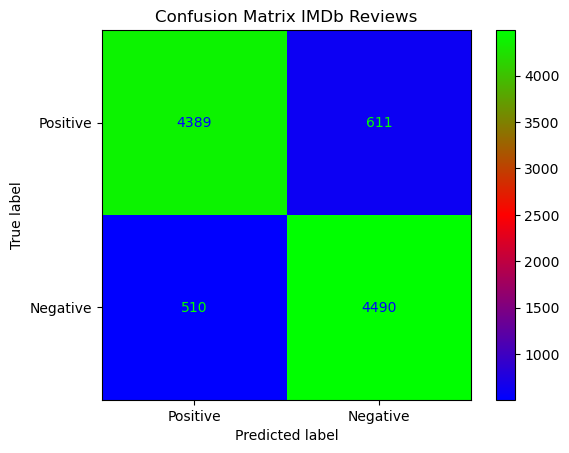

In [44]:
cm_lg = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lg, display_labels=["Positive","Negative" ])
disp.plot(cmap='brg')
plt.title("Confusion Matrix IMDb Reviews")
plt.grid(False)
plt.show()

### **RandomForest**

In [97]:
# Из коробки 
model_RF = RandomForestClassifier()

In [ ]:
# Создание модели случайного леса с настройками гиперпараметров
model_RF = RandomForestClassifier(
    n_estimators=100,              # Количество деревьев в лесу
    # n_estimators=1000,          # Можно увеличить число деревьев для повышения точности
    random_state=42,               # Фиксируем генератор случайных чисел для повторяемости
    # max_depth=None,             # Максимальная глубина дерева (по умолчанию без ограничения)
    max_depth=20,                  # Ограничение глубины дерева может предотвратить переобучение
    min_samples_split=5,           # Минимальное число образцов для разбиения узла
    # min_samples_split=2,        # Можно уменьшить для более глубоких деревьев
    min_samples_leaf=2,            # Минимальное число образцов в листе
    # min_samples_leaf=1,         # Можно уменьшить для более сложных деревьев
    # max_features='auto',        # Количество признаков, рассматриваемых при разбиении
    max_features='sqrt',           # Обычно 'sqrt' (корень из общего числа признаков)
    max_leaf_nodes=50,             # Максимальное число листьев в дереве
    # max_leaf_nodes=None,        # Без ограничения
    criterion='entropy',           # Критерий разбиения (можно попробовать 'gini' для сравнения)
    bootstrap=True,                # Бутстрэп-выборка для обучения каждого дерева
    # oob_score=True,             # Использовать внепосевную оценку (для оценки качества)
    oob_score=True,                # Включение оценки качества внепосевной оценкой
    n_jobs=-1,                     # Использовать все доступные ядра для ускорения обучения
    verbose=1,                     # Выводить прогресс во время обучения (по желанию)
    # class_weight='balanced'     # Взвешивание классов (если дисбаланс)
)


In [98]:
model_RF.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [101]:
# предсказания 
y_pred_rf = model_RF.predict(X_test_tfidf)

### Шаг 4.1 Метрики качества

In [102]:
# Оценка качества
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Точность метрики accuracy_rf : {accuracy_rf:.4f}')


Точность метрики accuracy_rf : 0.8468


In [103]:
precision_rf = precision_score(y_test, y_pred_rf)
print(f'Точность метрики precision_rf: {precision_rf:.4f}')


Точность метрики precision_rf: 0.8556


In [104]:
recall_rf = recall_score(y_test, y_pred_rf)
print(f'Точность метрики recall_rf : {recall_rf:.4f}')

Точность метрики recall_rf : 0.8344


In [105]:
f1_rf = f1_score(y_test,y_pred_rf)
print(f'Точность метрики f1_rf: {f1_rf:.4f}') 

Точность метрики f1_rf: 0.8449


In [106]:
# Получим вероятности положительного класса для тестовой выборки
y_pred_proba_rf = model_RF.predict_proba(X_test_tfidf)[:, 1]

In [107]:
# Вычислим ROC AUC
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.9560


In [108]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_rf)

# Находим порог, дающий максимальное значение F1
f1_scores = [f1_score(y_test, y_pred_proba_rf >= thr) for thr in thresholds]
best_idx = f1_scores.index(max(f1_scores))
best_threshold = thresholds[best_idx]

print(f"Лучший порог по F1: {best_threshold:.3f}")


Лучший порог по F1: 0.450


In [109]:
# Общая Оценка
print(classification_report(y_test, y_pred_rf, target_names=['Negative (0)', 'Positive (1)']))

              precision    recall  f1-score   support

Negative (0)       0.84      0.86      0.85      5000
Positive (1)       0.86      0.83      0.84      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



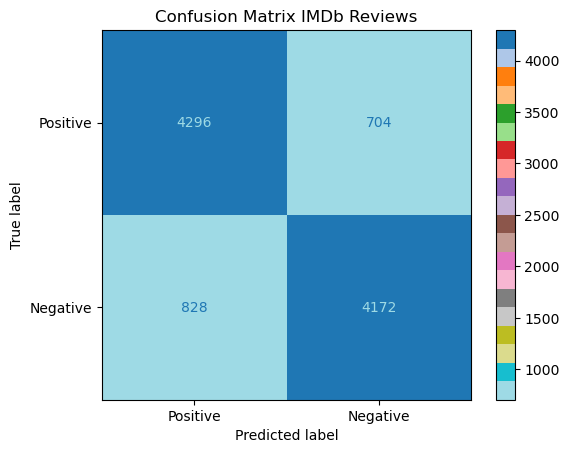

In [110]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Positive","Negative"])
disp.plot(cmap='tab20_r')
plt.title("Confusion Matrix IMDb Reviews")
plt.grid(False)
plt.show()

### **Catboost**

In [112]:
# Создаем Pool для обучения и теста
train_pool = Pool(X_train_tfidf, y_train)
test_pool = Pool(X_test_tfidf, y_test)


In [ ]:
model_cb = CatBoostClassifier(
    iterations=1500,                     # Максимальное количество итераций (эпох) обучения
    depth=8,                             # Глубина дерева
    learning_rate=0.05,                  # Скорость обучения (шаг градиентного спуска)
    l2_leaf_reg=3,                       # Регуляризация L2 для листьев (часто помогает бороться с переобучением)
    task_type='CPU',                     # Тип задачи: обучение на CPU (может быть 'GPU' для обучения на GPU)
    random_seed=42,                      # Сид случайных чисел для воспроизводимости
    verbose=100,                         # Частота вывода информации о процессе обучения (каждые 100 итераций)
    loss_function='Logloss',             # Функция потерь: логарифмическая потеря для задач классификации
    eval_metric='AUC',                   # Метрика для оценки на валидационной выборке: площадь под ROC-кривой
    leaf_estimation_method='Newton',    # Метод оценки листьев: 'Newton' или 'Gradient'
    border_count=128,                    # Количество границ для бокс-кодирования данных (идет в предобработке категориальных признаков)
    thread_count=4,                      # Количество потоков для параллелизации
    logging_level='Verbose',             # Уровень логирования: 'Verbose' для подробных сообщений
    use_best_model=True,                 # Использовать лучшую модель по метрике на валидации
    metric_period=50,                    # Интервал между расчетами метрик и выводом статистики
    grow_policy='Depthwise',             # Политика роста дерева ('Depthwise' или 'SymmetricTree')
    max_ctr_complexity=4,                # Максимальная сложность CTR-преобразований (для категориальных признаков)
    bagging_temperature=1,               # Температура бэггинга, влияет на рандомизацию при обучении
    fold_len_multiplier=2,               # Множитель длины фолда, влияет на интервал пересоздания фолдов
)


In [113]:
model_CB = CatBoostClassifier()

In [107]:
# Обучение модели из коробки
model_cb.fit(train_pool, eval_set=test_pool, use_best_model=True)


0:	learn: 0.6775684	test: 0.6772687	best: 0.6772687 (0)	total: 1.5s	remaining: 37m 34s
100:	learn: 0.4321114	test: 0.4350923	best: 0.4350923 (100)	total: 2m 32s	remaining: 35m 13s
200:	learn: 0.3794074	test: 0.3880281	best: 0.3880281 (200)	total: 4m 59s	remaining: 32m 14s
300:	learn: 0.3410376	test: 0.3592346	best: 0.3592346 (300)	total: 7m 24s	remaining: 29m 32s
400:	learn: 0.3124552	test: 0.3418348	best: 0.3418348 (400)	total: 9m 50s	remaining: 26m 57s
500:	learn: 0.2899562	test: 0.3296101	best: 0.3296101 (500)	total: 12m 29s	remaining: 24m 53s
600:	learn: 0.2715764	test: 0.3209423	best: 0.3209423 (600)	total: 15m 16s	remaining: 22m 50s
700:	learn: 0.2558324	test: 0.3139815	best: 0.3139815 (700)	total: 18m 14s	remaining: 20m 47s
800:	learn: 0.2422398	test: 0.3087915	best: 0.3087915 (800)	total: 21m 19s	remaining: 18m 36s
900:	learn: 0.2301219	test: 0.3044107	best: 0.3044107 (900)	total: 24m	remaining: 15m 57s
1000:	learn: 0.2190924	test: 0.3007011	best: 0.3007011 (1000)	total: 26m 37

In [ ]:
# Обучение модели
model_CB.fit(train_pool, eval_set=test_pool, use_best_model=True,verbose=100)

In [108]:
# Предсказания на тестовой выборке
y_pred = model_cb.predict(test_pool)

In [116]:
# Предсказания на тестовой выборке
y_pred = model_CB.predict(test_pool)

In [117]:
# Оценка качества
accuracy_cb = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy_cb:.4f}')

Точность модели: 0.8788


### Шаг 4.1 Метрики качества

In [123]:
# Оценка качества
accuracy_cb = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy_cb:.4f}')

Точность модели: 0.8788


In [124]:
precision_cb = precision_score(y_test, y_pred)
print(f'Точность метрики precision_cb: {precision_cb:.4f}')


Точность метрики precision_cb: 0.8683


In [125]:
recall_cb = recall_score(y_test, y_pred)
print(f'Точность метрики recall_cb : {recall_cb:.4f}')


Точность метрики recall_cb : 0.8930


In [126]:
f1_cb = f1_score(y_test,y_pred)
print(f'Точность метрики f1_cb: {f1_rf:.4f}') 

Точность метрики f1_cb: 0.8449


In [127]:
# Полный отчет по классификации
print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))

              precision    recall  f1-score   support

Negative (0)       0.89      0.86      0.88      5000
Positive (1)       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [113]:
# Полный отчет по классификации
print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))


              precision    recall  f1-score   support

Negative (0)       0.89      0.87      0.88      5000
Positive (1)       0.87      0.90      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [129]:
# Получим вероятности положительного класса для тестовой выборки
y_pred_proba_cb = model_CB.predict_proba(X_test_tfidf)[:, 1]

In [130]:
# Вычислим ROC AUC
roc_auc_cb = roc_auc_score(y_test, y_pred_proba_cb)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.9560


In [131]:
# Находим порог, дающий максимальное значение F1
f1_scores = [f1_score(y_test, y_pred_proba_cb >= thr) for thr in thresholds]
best_idx = f1_scores.index(max(f1_scores))
best_threshold = thresholds[best_idx]

print(f"Лучший порог по F1: {best_threshold:.3f}")

Лучший порог по F1: 0.490


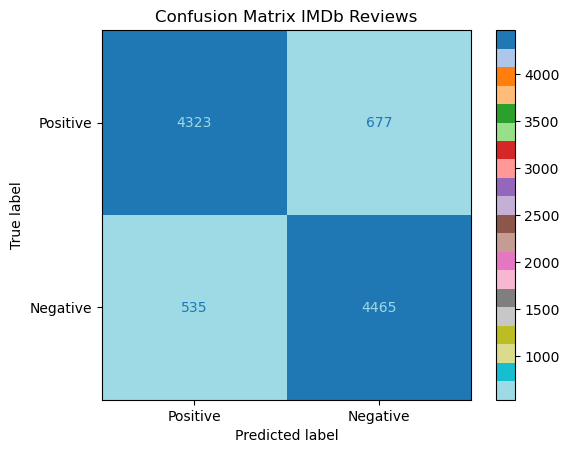

In [152]:
cm_cb = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cb, display_labels=["Positive","Negative"])
disp.plot(cmap='tab20_r')
plt.title("Confusion Matrix IMDb Reviews")
plt.grid(False)
plt.show()

### **Lightgbm**

In [122]:
import lightgbm as lgb

In [132]:
# Из коробки
model_lgb = lgb.LGBMClassifier()

In [133]:
model_lgb

LGBMClassifier()

In [135]:
model_lgb.fit(X_train_tfidf,y_train)

[LightGBM] [Info] Number of positive: 20000, number of negative: 20000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.428449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 556170
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier()

In [141]:
# Предсказания
y_pred_lgb = model_lgb.predict(X_test_tfidf)

### Шаг 4.1 Метрики качества

In [145]:
# Оценка качества
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f'Точность модели: {accuracy_lgb:.4f}')

Точность модели: 0.8618


In [146]:
precision_lgb = precision_score(y_test, y_pred_lgb)
print(f'Точность метрики precision_cb: {precision_lgb:.4f}')


Точность метрики precision_cb: 0.8519


In [148]:
recall_lgb = recall_score(y_test, y_pred_lgb)
print(f'Точность метрики recall_cb : {recall_lgb:.4f}')

Точность метрики recall_cb : 0.8758


In [147]:
f1_lgb = f1_score(y_test,y_pred_lgb)
print(f'Точность метрики f1_lgb: {f1_lgb:.4f}')

Точность метрики f1_lgb: 0.8637


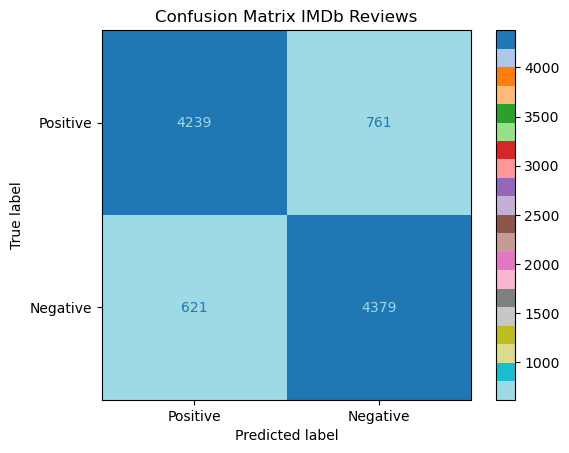

In [149]:
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=["Positive","Negative"])
disp.plot(cmap='tab20_r')
plt.title("Confusion Matrix IMDb Reviews")
plt.grid(False)
plt.show()